In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from scipy.sparse.linalg import gmres, LinearOperator
from util.unet import *

### Fully Connected Neural network in the Fourier Domain
We start with a simple approach, a fully connected network with one hidden layer. The objective is to minimise the mean square error of the fourier coefficients. How many nodes is enough in the hidden layer? 

Shape: torch.Size([200, 4, 41])


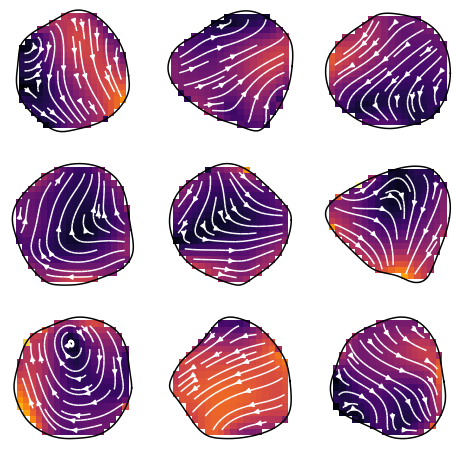

In [2]:
data = torch.load("/home/emastr/phd/data/problem_data.torch")
x = data["X"] # Remove later
y = data["Y"]
print(f"Shape: {x.shape}")

N = x.shape[0]
K_in = x.shape[2] // 2
K_out = y.shape[2] // 2

# 2*5*5*1
#grid = GaussLegGrid(segments=np.linspace(0,np.pi*2,8), corners=None)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    data = ProblemData(bound_coef = (x[i, 0, :] + 1j * x[i, 1, :]).numpy(), 
                       u_coef = (x[i, 2, :] + 1j * x[i, 3, :]).numpy(), 
                       density_coef=(y[i, 0, :] + 1j * y[i, 1, :]).numpy())
    problem = data.to_problem(n=4)
    field = lambda z: np.abs(problem.evaluate(z))
    
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
    plt.axis("equal")
    remove_axes(plt.gca())
   

<Figure size 1080x720 with 0 Axes>

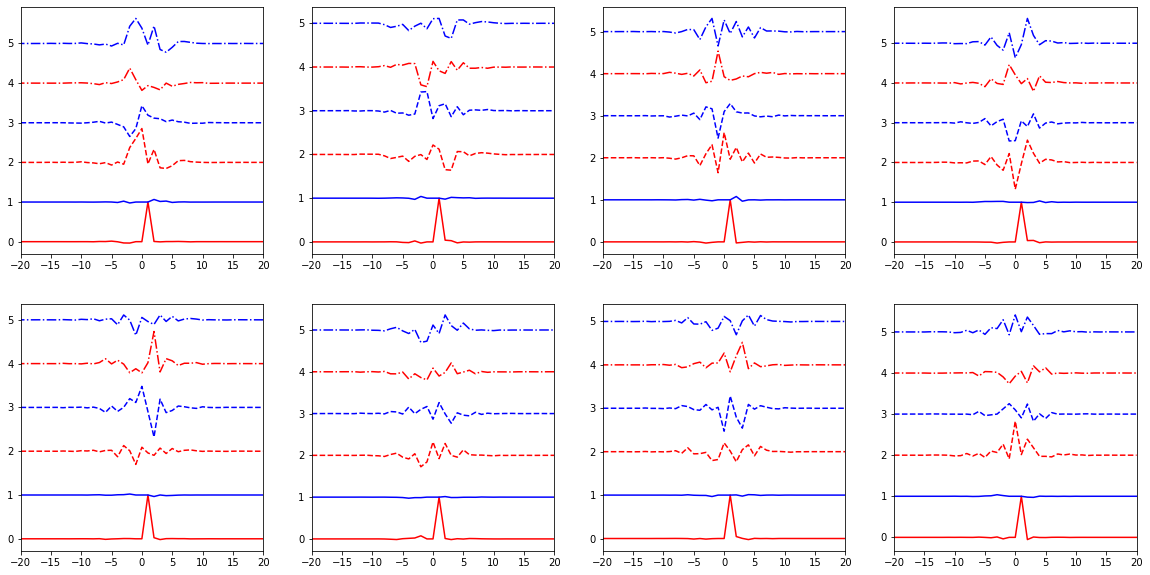

In [3]:
plt.figure(figsize=(15,10))
k_in = np.linspace(-K_in, K_in, 2*K_in+1)
k_out = np.linspace(-K_out, K_out, 2*K_out+1)

abs_k_in = np.abs(k_in)**0
abs_k_out = np.abs(k_out)**0

plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4, i+1)
    i = 74 + i
    plt.plot(k_in, x[i, 0, :]*abs_k_in, 'r-')
    plt.plot(k_in, x[i, 1, :]*abs_k_in+1, 'b-')
    plt.plot(k_in, x[i, 2, :]*abs_k_in+2, 'r--')
    plt.plot(k_in, x[i, 3, :]*abs_k_in+3, 'b--') 
    plt.plot(k_out, y[i, 0, :]*abs_k_out+4, 'r-.')
    plt.plot(k_out, y[i, 1, :]*abs_k_out+5, 'b-.')
    plt.xlim([-20,20])
    #plt.yscale("log")
    

In [51]:
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_dtype(torch.float32)

device = "cpu"


d_in = x.shape[1] * x.shape[2]
d_out = y.shape[1] * y.shape[2]
d_hide = 2*d_in // 1

xflat = x.view(N, d_in).to(device)
yflat = y.view(N, d_out).to(device)

class Net(torch.nn.Module):
    def __init__(self, w_hidden, preweight=1.0, postweight=1.0):
        super(Net, self).__init__()
        self.preweight = preweight
        self.postweight = postweight
        self.activation = nn.Sigmoid() # F.relu
        
        # Create layers according to user specified list of widths
        self.input_layer = nn.Linear(in_features=d_in, out_features=w_hidden[0], bias=True)
        
        # hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(in_features=w_hidden[i], out_features=w_hidden[i+1], bias=True)\
                                            for i in range(len(w_hidden)-1)])
        
        self.output_layer = nn.Linear(in_features=w_hidden[-1], out_features=d_out, bias=True)
        
            
    def forward(self, x):
        x = self.activation(self.input_layer(self.preweight * x))
        for layer in self.hidden_layers:
            #if layer.weight.shape[0] == layer.weight.shape[1]:
                # Use resnet connection
            x = self.activation(layer(x)) + x
            #else:
                # Use standard connection
             #   x = self.activation(layer(x))
        
        x = self.output_layer(x)
        return self.postweight * x
    
    def evaluate(self, bound_coef, u_coef):        
        x = torch.zeros(1, 4, K_in * 2 + 1)
        x[0,0,:] = torch.from_numpy(np.real(bound_coef))
        x[0,1,:] = torch.from_numpy(np.imag(bound_coef))
        x[0,2,:] = torch.from_numpy(np.real(u_coef))
        x[0,3,:] = torch.from_numpy(np.imag(u_coef))
        xflat = x.view(1, d_in)
        
        y = self(xflat)
        y = y.view(1, 2, 2*K_out + 1)
        return (y[0,0,:] + 1j*y[0,1,:]).cpu().detach().numpy()
        



We initiate a network, loss, regularisation and optimisers. We also divide the data into test and train.

In [52]:
#w_hidden = [d_in//i for i in [1,2,4,8,4]]
#net = Net(w_hidden=w_hidden, preweight=1., postweight=1.).to(device)
net = Net(w_hidden=5*[d_hide], preweight=1., postweight=1.).to(device)
#net.to("cuda")
mseloss = nn.MSELoss()
#mseloss = nn.L1Loss()

# Regularisation
reg = torch.zeros(1, d_out).to(device)
#absfreq = 1 + torch.linspace(-K_out, K_out, 2*K_out+1).abs().to(device)
absfreq = torch.exp(0.2*torch.linspace(-K_out, K_out, 2*K_out+1).abs()).to(device)
reg[:, 0:d_out//2] = absfreq ** 1
reg[:, d_out//2:] = absfreq ** 1

loss = lambda x,y: mseloss(x, y) #+ 0.01*mseloss(reg * x, torch.zeros_like(x))
#optim = torch.optim.SGD(params=net.parameters(), lr=1e-5)
optim = torch.optim.Adam(params=net.parameters(), weight_decay=1e-7)

losses = []
testlosses = []

# Step inside loop
def step(xflat, yflat):
    optim.zero_grad()
    loss_x = loss(net(xflat), yflat)
    loss_x.backward()
    optim.step()
    return loss_x.item()

    
xtest = xflat[150:]
ytest = yflat[150:]

Train the network for some epochs.

In [53]:
Nsteps = int(4e4)
for i in range(Nsteps):
    idx = torch.randperm(xflat.shape[0]-50)[:]
    #idx = 0 # Always pick first data point
    xsample = xflat[idx, :]
    ysample = yflat[idx, :]
    loss_x = step(xsample, ysample)
    if i%500 == 0:
        #optim = torch.optim.Adam(params=net.parameters(), weight_decay=10**(-i/7e3))
        losses.append(loss_x)
        testlosses.append(loss(net(xtest), ytest).item())
        
        delta = torch.abs(net(xtest) - ytest)
        maxer = delta.max()
        
        #idx = delta.argmax()
        #row = (idx // delta.shape[1]).item()
        #col = (idx - row * delta.shape[1]).item()
        #rmse  = delta.mean()
        #print(f"{i}/{Nsteps} done, maxer = {maxer:.2f} at idx = {row, col}, rmse = {rmse:.2f}", end="\r")
        print(f"{i}/{Nsteps} done, test maxer = {maxer:.6f}, loss={losses[-1]}, testloss={testlosses[-1]}", end="\r")
    

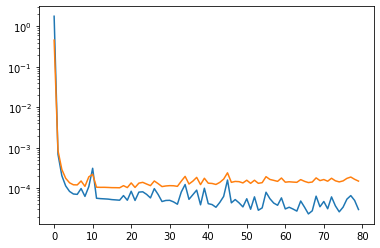

In [54]:
plt.semilogy(losses)  
plt.semilogy(testlosses)

tensor(2.4592e-05, grad_fn=<MseLossBackward0>)


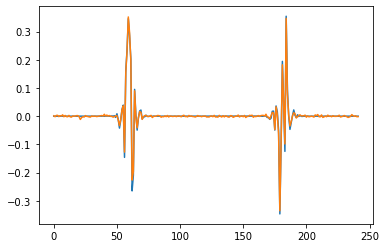

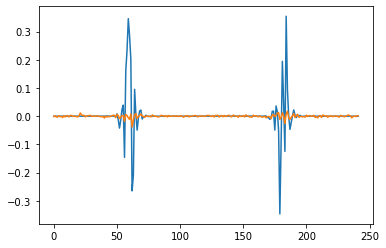

In [55]:
net.to(device)
ytrue = yflat[0,:].cpu().detach().numpy()
ypred = net(xflat[0,:]).cpu().detach().numpy()

plt.plot(ytrue)
plt.plot(ypred)

plt.figure()
plt.plot(ytrue)
plt.plot(ytrue-ypred)
print(loss(net(xflat[0,:]), yflat[0,:]))

RMS: 0.07657908791887542


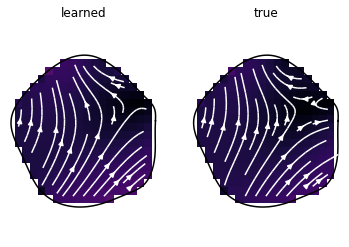

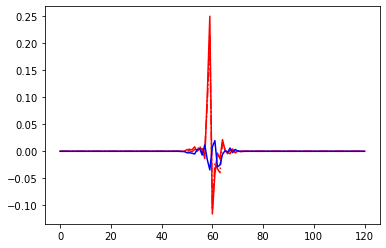

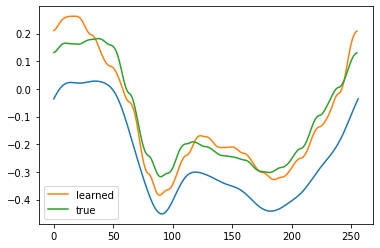

In [56]:
data = ProblemData.random_problemdata(K=K_in, 
                                      bound_amplitude=0.2,#0.1,
                                      bound_decay=0.6,#0.5 
                                      cond_amplitude=0.2,
                                      cond_decay=0.6,
                                      allow_intersections=False, 
                                      allow_net_flow=False,
                                      decay_type="exp",
                                      refine=4,
                                      tol=1e-13)


net.to("cpu")
data.density_coef = net.evaluate(data.bound_coef, data.u_coef)
K_w = (len(data.density_coef)-1)//2
data.density_coef[0:K_w-10] = 0.
data.density_coef[K_w+10:] = 0.

problem = data.to_problem(n=4)
learned = data.density_coef
#print(xflat.shape)
#print(net(xflat[0:1,:].to("cpu")))

titles = ["learned", "true"]
field = lambda z: np.abs(problem.evaluate(z))
dens = []


for i in range(2):
    plt.subplot(1,2,i+1)
    if i == 1:
        problem.solve()
    dens.append(problem.density.copy())
    plt.title(titles[i])
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
    plt.axis("equal")
    remove_axes(plt.gca())
    
    inlet = problem.condition


plt.figure()
data.set_density(n=4, K_density=K_out)
plt.plot(np.real(learned), 'r-')
plt.plot(np.real(data.density_coef), 'r-.')
plt.plot(np.real(data.density_coef)-np.real(learned), 'b-')

print(f"RMS: {(np.abs(dens[0]-dens[1])**2).mean()**0.5}")
plt.figure()
plt.plot(-np.imag(inlet(np.linspace(0,2*np.pi,257))))
for i in range(2):
    plt.plot(np.real(dens[i]), label=titles[i])
plt.legend()


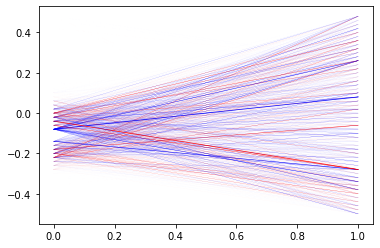

In [21]:
# Ok: 5*(2d_in), weight decay of 1e-7

pars = net.parameters()
j = 0

def plot_layer(i,W):
    N2, N1 = W.shape
    for n in range(N1):
        for m in range(N2):
            w = W[m,n]
            plt.plot([i, i+1], [(n-N1//2)/N1,(m-N2//2)/N2], linewidth=(w**2)*10, color="b" if w<0 else "r")
    
#for i,l in enumerate(net.hidden_layers):
#    plot_layer(i, l.weight)       
plot_layer(0, net.input_layer.weight[0:50,0:50])